In [1]:
# Including required python libraries used in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, SimpleRNN,LSTM, Activation
from keras.utils import np_utils

import emoji

In [2]:
# getting the train and test data
train_data = pd.read_csv('train_emoji.csv',header=None)
test_data = pd.read_csv('test_emoji.csv',header=None)

In [3]:
# Displaying top 5 rows
train_data.head()

,0,1,2,3
0,never talk to me again,3,NaN,NaN
1,I am proud of your achievements,2,NaN,NaN
2,It is the worst day in my life,3,NaN,NaN
3,Miss you so much,0,NaN,[0]
4,food is life,4,NaN,NaN


In [5]:
# Checking data by showing first 5 rows of the test data
test_data.head()

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


In [6]:
#A dictionary for emoji's
dict_emojis = { 0 : ":heart:", 1 : ":baseball:", 2 : ":smile:", 3 : ":disappointed:", 4 : ":fork_and_knife:",5 : ":angry:"}

In [7]:
#printing the emojis from the dictionary using emojize
for emoj in dict_emojis.keys():
    print (emoj,end=" ")
    print (emoji.emojize(dict_emojis[emoj], use_aliases=True))

0 ❤️
1 ⚾
2 😄
3 😞
4 🍴
5 😠


In [9]:
#Splitting the input and labels
X_train = train_data[0]
Y_train = train_data[1]

X_test = test_data[0]
Y_test = test_data[1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_train[2],Y_train[2])

(157,) (157,) (68,) (68,)
-------------------------
It is the worst day in my life 3


In [11]:
# Splitting the train data from sentences to words
for sentence in range(X_train.shape[0]):
    X_train[sentence] = X_train[sentence].split()

# Splitting the test data from sentences to words
for sentence in range(X_test.shape[0]):
    X_test[sentence] = X_test[sentence].split()
    
#Lables in to categorical form
Y_train = np_utils.to_categorical(Y_train)

C:\Users\nsrag\AppData\Local\Temp/ipykernel_5720/716890783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[sentence] = X_train[sentence].split()
C:\Users\nsrag\AppData\Local\Temp/ipykernel_5720/716890783.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[sentence] = X_test[sentence].split()


In [13]:
#Printing the label and data after the conversion
print (X_train[2],Y_train[2])

['It', 'is', 'the', 'worst', 'day', 'in', 'my', 'life'] [0. 0. 0. 1. 0. 0.]


In [14]:
#checking the max length in the training data
np.unique(np.array([len(i) for i in X_train]) , return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 4,  7, 30, 42, 29, 23, 12,  5,  1,  4], dtype=int64))

In [15]:
#checking the max length in the test data
np.unique(np.array([len(i) for i in X_test]) , return_counts=True)

(array([2, 3, 4, 5, 6, 7, 8]),
 array([ 5, 13, 17, 23,  3,  5,  2], dtype=int64))

In [16]:
# Creating  embeddings dictionary with key = word and value = list of words in glove vector
embeddings_index = {}

f = open('glove.6B.50d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
# Checking length of a particular word
embeddings_index["i"].shape

(50,)

In [18]:
from scipy import spatial
# Checking cosine similarity of words india and paris
1 - spatial.distance.cosine(embeddings_index["india"], embeddings_index["paris"])

0.24696819484233856

In [19]:
#Similarity of words france and paris
1-spatial.distance.cosine(embeddings_index["france"], embeddings_index["paris"])

0.802532970905304

In [20]:
# Filling the embedding matrix
embedding_matrix_train = np.zeros((X_train.shape[0], 10, 50))
embedding_matrix_test = np.zeros((X_test.shape[0], 10, 50))

for i in range(X_train.shape[0]):
    for j in range(len(X_train[i])):
        embedding_matrix_train[i][j] = embeddings_index[X_train[i][j].lower()]
        
for ix in range(X_test.shape[0]):
    for ij in range(len(X_test[ix])):
        embedding_matrix_test[ix][ij] = embeddings_index[X_test[ix][ij].lower()]        

In [21]:
print (embedding_matrix_train.shape, embedding_matrix_test.shape)

(157, 10, 50) (68, 10, 50)


# Training model

## - Using RNN

In [35]:
def RNN_model(loss_function,activation_func,drop_out_rate):
    # A simple RNN network to classify the emoji class from an input Sentence

    model = Sequential()
    model.add(SimpleRNN(64, input_shape=(10,50), return_sequences=True))
    model.add(Dropout(drop_out_rate))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(6))
    model.add(Activation(activation_func))

    model.summary()
    
    # Setting Loss and Optimiser for the model
    model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
    
    # Training of the model and Setting hyperparameters for the model
    hist = model.fit(embedding_matrix_train,Y_train,epochs = 50, batch_size=32,shuffle=True)
    return model

In [36]:
def get_accuracy(model,embedding_matrix_test,Y_test):
    # Prediction of trained model
    pred_lstm=model.predict(embedding_matrix_test)
    classes_lstm=np.argmax(pred_lstm,axis=1)
    # Calculating accuracy / score  of the model
    return float(sum(classes_lstm==Y_test))/embedding_matrix_test.shape[0],classes_lstm

In [37]:
active_func = 'softmax'
loss_func = 'MeanSquaredError'
#loss_func = 'categorical_crossentropy'
drop_out = 0.2
trained_model_rnn = RNN_model(loss_func,active_func,drop_out)
accuracy_rnn,pred_classlabels = get_accuracy(trained_model_rnn,embedding_matrix_test,Y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 10, 64)            7360      
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 activation_6 (Activation)   (None, 6)                 0         
                                                                 
Total params: 16,006
Trainable params: 16,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 

In [38]:
print('Accuracy - ' + str(accuracy_rnn*100) + '%')

Accuracy - 60.29411764705882%


### Displaying Prediction vs Actual - for wrongly classified labels

In [41]:
# Printing the sentences with the predicted and labled emoji
for ix in range(embedding_matrix_test.shape[0]):
    
    if pred_classlabels[ix] != Y_test[ix]:
        print(ix)
        print (test_data[0][ix],end=" ")
        print (emoji.emojize(dict_emojis[pred_classlabels[ix]], use_aliases=True),end=" ")
        print (emoji.emojize(dict_emojis[Y_test[ix]], use_aliases=True))

5
['he', 'is', 'a', 'good', 'friend'] 😄 ❤️
7
['We', 'had', 'such', 'a', 'lovely', 'dinner', 'tonight'] 🍴 ❤️
12
['This', 'girl', 'is', 'messing', 'with', 'me'] 😄 😠
13
['are', 'you', 'serious', 'ha', 'ha'] 😞 😄
17
['Congratulation', 'for', 'having', 'a', 'baby'] 😄 ❤️
18
['stop', 'messing', 'around'] 😄 😠
23
['she', 'is', 'a', 'bully'] ❤️ 😞
24
['Why', 'are', 'you', 'feeling', 'bad'] 🍴 😞
26
['I', 'worked', 'during', 'my', 'birthday'] 😄 😞
28
['enjoy', 'your', 'break'] ⚾ 😄
29
['valentine', 'day', 'is', 'near'] 🍴 ❤️
32
['My', 'life', 'is', 'so', 'boring'] ❤️ 😞
35
['he', 'can', 'pitch', 'really', 'well'] 😠 ⚾
39
['I', 'like', 'to', 'laugh'] ❤️ 😄
42
['i', 'miss', 'her'] ❤️ 😞
45
['I', 'love', 'to', 'the', 'stars', 'and', 'back'] ⚾ ❤️
46
['What', 'you', 'did', 'was', 'awesome'] ❤️ 😄
48
['I', 'want', 'to', 'joke'] ❤️ 😄
49
['go', 'away'] 😞 😠
50
['yesterday', 'we', 'lost', 'the', 'match'] ⚾ 😞
51
['family', 'is', 'all', 'I', 'have'] 😞 ❤️
52
['you', 'are', 'failing', 'this', 'exercise'] ❤️ 😞
56
['I', 'ca

In [42]:
# Predicting for our random sentence
x = ['i','am','mad','at','you']

x_ = np.zeros((1,10,50))

for ix in range(len(x)):
    x_[0][ix] = embeddings_index[x[ix].lower()]

In [45]:
pred_random=trained_model_rnn.predict(x_)
classes_random=np.argmax(pred_random)
print (emoji.emojize(dict_emojis[classes_random], use_aliases=True))

😠


##  - Using LSTM

In [46]:
def LTSM_model(loss_function,activation_func,drop_out_rate):
    
    print("------------------------------------------------------------------------------------------------")
    print('LTSM Model for '+activation_func+' with loss function '+loss_function+' and drop out :- '+str(drop_out_rate))
    # A simple LSTM network
    model = Sequential()
    model.add(LSTM(128, input_shape=(10,50), return_sequences=True))
    model.add(Dropout(drop_out_rate))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(6))
    model.add(Activation(activation_func))

    model.summary()
    
    # Setting Loss ,Optimiser for model
    model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
    
    #training the model
    hist = model.fit(embedding_matrix_train,Y_train,epochs = 50, batch_size=32,shuffle=True)
    print("-------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------")
    return model

In [47]:
def get_accuracy(model,embedding_matrix_test,Y_test):
    # Prediction of trained model
    pred_lstm=model.predict(embedding_matrix_test)
    classes_lstm=np.argmax(pred_lstm,axis=1)
    # Calculating accuracy / score  of the model
    return float(sum(classes_lstm==Y_test))/embedding_matrix_test.shape[0],classes_lstm

In [48]:
# Using Sigmoid/softmax as an activation function for LTSM with a couple o loss functions and drop-out rates
active_func = 'softmax'
#loss_func = 'MeanSquaredError'
loss_func = 'categorical_crossentropy'
drop_out = 0.2
trained_model = LTSM_model(loss_func,active_func,drop_out)
accuracy,pred_classlabels = get_accuracy(trained_model,embedding_matrix_test,Y_test)

------------------------------------------------------------------------------------------------
LTSM Model for softmax with loss function categorical_crossentropy and drop out :- 0.2
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout_7 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
 activation_7 (Activation)   (None, 6)                 0         
                                                                 
To

### ACCURACY

In [49]:
print('Accuracy - ' + str(accuracy*100) + '%')

Accuracy - 58.82352941176471%


In [51]:
# Printing the sentences with the predicted and the labelled emoji
for ix in range(embedding_matrix_test.shape[0]):
    
    if pred_classlabels[ix] != Y_test[ix]:
        print(ix)
        print (test_data[0][ix],end=" ")
        print (emoji.emojize(dict_emojis[pred_classlabels[ix]], use_aliases=True),end=" ")
        print (emoji.emojize(dict_emojis[Y_test[ix]], use_aliases=True))

2
['he', 'got', 'a', 'raise'] 😞 😄
3
['she', 'got', 'me', 'a', 'present'] 😄 ❤️
5
['he', 'is', 'a', 'good', 'friend'] 😄 ❤️
7
['We', 'had', 'such', 'a', 'lovely', 'dinner', 'tonight'] 😄 ❤️
11
['work', 'is', 'hard'] 😄 😞
12
['This', 'girl', 'is', 'messing', 'with', 'me'] ❤️ 😠
13
['are', 'you', 'serious', 'ha', 'ha'] 😞 😄
16
['work', 'is', 'horrible'] 😄 😞
17
['Congratulation', 'for', 'having', 'a', 'baby'] 😄 ❤️
21
['you', 'brighten', 'my', 'day'] ❤️ 😄
23
['she', 'is', 'a', 'bully'] ❤️ 😞
26
['I', 'worked', 'during', 'my', 'birthday'] 😄 😞
28
['enjoy', 'your', 'break'] ⚾ 😄
29
['valentine', 'day', 'is', 'near'] 😄 ❤️
32
['My', 'life', 'is', 'so', 'boring'] ❤️ 😞
40
['I', 'will', 'go', 'dance'] ⚾ 😄
42
['i', 'miss', 'her'] ❤️ 😞
48
['I', 'want', 'to', 'joke'] 😞 😄
49
['go', 'away'] ⚾ 😠
50
['yesterday', 'we', 'lost', 'the', 'match'] ⚾ 😞
51
['family', 'is', 'all', 'I', 'have'] 🍴 ❤️
54
['You', 'totally', 'deserve', 'this', 'prize'] 😞 😄
55
['I', 'did', 'not', 'have', 'breakfast'] 🍴 😞
57
['Dont', 'annoy', '

In [52]:
# Predicting for our random sentence
x = ['i','am','mad','at','you']

x_ = np.zeros((1,10,50))

for ix in range(len(x)):
    x_[0][ix] = embeddings_index[x[ix].lower()]

In [53]:
pred_random=trained_model.predict(x_)
classes_random=np.argmax(pred_random)
print (emoji.emojize(dict_emojis[classes_random], use_aliases=True))

😄


In [73]:
pred_random

array([[1.5977007e-01, 2.1234270e-04, 7.5378764e-01, 1.0004493e-02,
        3.7636608e-02, 3.8588807e-02]], dtype=float32)

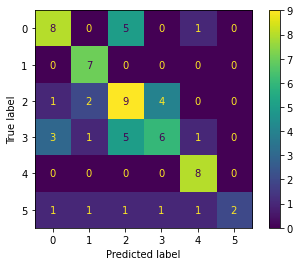

In [54]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, pred_classlabels)
cm_obj = ConfusionMatrixDisplay(cm)
cm_obj.plot()

In [55]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print('Precision is - ' +str(precision_score(Y_test, pred_classlabels,average = 'micro' )))


print('Recall is - ' + str(recall_score(Y_test, pred_classlabels,average = 'micro' )))

Precision is - 0.5882352941176471
Recall is - 0.5882352941176471
